In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import string
import contractions
from nltk.tokenize import RegexpTokenizer
import fasttext

ModuleNotFoundError: No module named 'contractions'

In [2]:
# loading the data
data = pd.read_csv('indeed_data.csv')
data.head(10)

,Unnamed: 0,rating,rating_title,rating_description,rating_pros,rating_cons
0,0,3.0,Good culture and peers,Very formal client oriented service consulting...,NaN,NaN
1,1,5.0,Productive and competitive workplace with many...,During a typical day at work we attend any cus...,"innovation, leading skills, be part of Deloitt...","Not at all, I love working."
2,2,2.0,Very stressful,Company is very focused on their profits rathe...,Great benefits,Extremely demanding
3,3,5.0,Excellent culture,The project I worked in is relaxed. The overal...,NaN,NaN
4,4,5.0,I love Deloitte!,Honestly if you feel like applying to work at ...,Treated equally,N/a
5,5,5.0,Challenging but incredible career opportunity,This is definitely a challenging and at times ...,NaN,NaN
6,6,3.0,Decent Job,Decent job. I would recommend to others. I jus...,NaN,NaN
7,7,4.0,Wonderful - and challenging place to work.,Unlimited opportunities to take your career in...,NaN,NaN
8,8,4.0,Very prestigious place to work at with long te...,Great company to build a long term career path...,Prestigious and you learn a lot quickly,Can be stressful at times and you will have hi...
9,9,4.0,Great place to learn and develop business acum...,I enjoy this job as my first job -- I think it...,"Learning opportunities, challenged, growth min...","Long hours at times, can get stressful as well..."


In [3]:
# removing the unnamed column
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# summary of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating              4179 non-null   float64
 1   rating_title        4177 non-null   object 
 2   rating_description  4179 non-null   object 
 3   rating_pros         1262 non-null   object 
 4   rating_cons         1194 non-null   object 
dtypes: float64(1), object(4)
memory usage: 163.4+ KB


In [5]:
# calculating the number of NA
data.isnull().sum()

rating                   0
rating_title             2
rating_description       0
rating_pros           2917
rating_cons           2985
dtype: int64

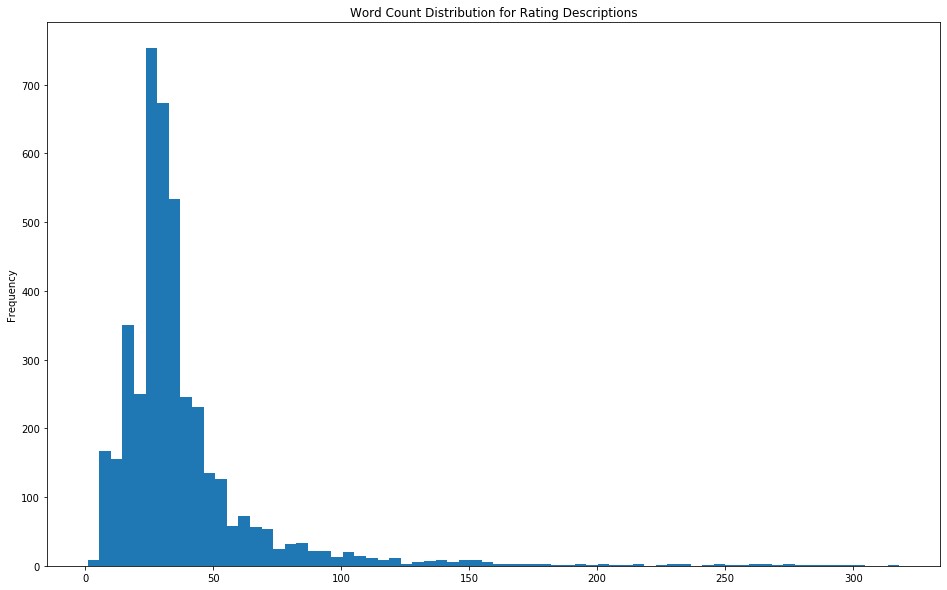

In [6]:
# Calculating the word count for rating description
data['word_count'] = data['rating_description'].apply(lambda x: len(str(x).split()))
# Plotting the word count
data['word_count'].plot(kind='hist',bins = 70,figsize = (16,10),title='Word Count Distribution for Rating Descriptions')

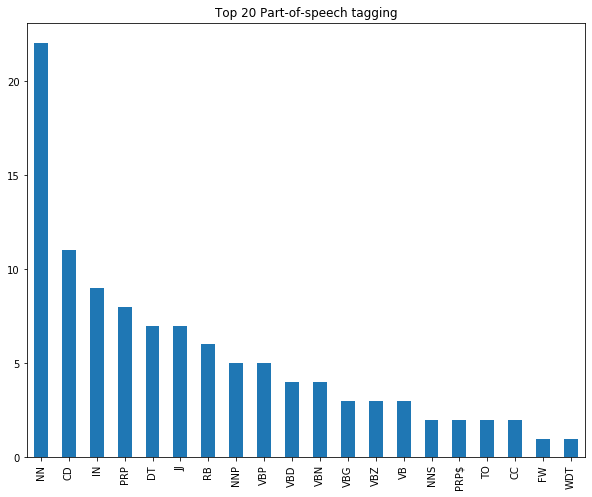

In [7]:
# The  20 top of  part-of-speech tags in the rating descriptions

from textblob import TextBlob
text = TextBlob(str(data['rating_description']))
df_pos = pd.DataFrame(text.tags, columns = ['word' , 'pos'])
df_pos = df_pos.pos.value_counts()[:20]
df_pos.plot(kind = 'bar', figsize=(10, 8), title = "Top 20 Part-of-speech tagging")

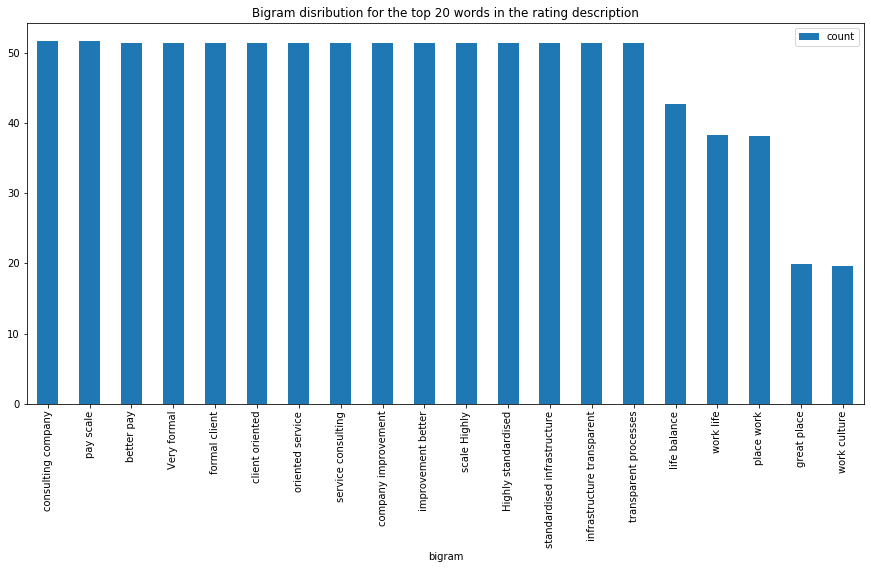

In [8]:
# Bigram Distribution

# Converting text rating descriptions into vectors using TF-IDF

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vector = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
matrix_tf = tf_vector.fit_transform(data['rating_description'])
words_count = matrix_tf.sum(axis=0) 
#Finding the word frequency
frequency = [(word, words_count[0, idx]) for word, idx in tf_vector.vocabulary_.items()]
frequency =sorted(frequency, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(frequency)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)
#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the rating description", figsize = (15,7), )


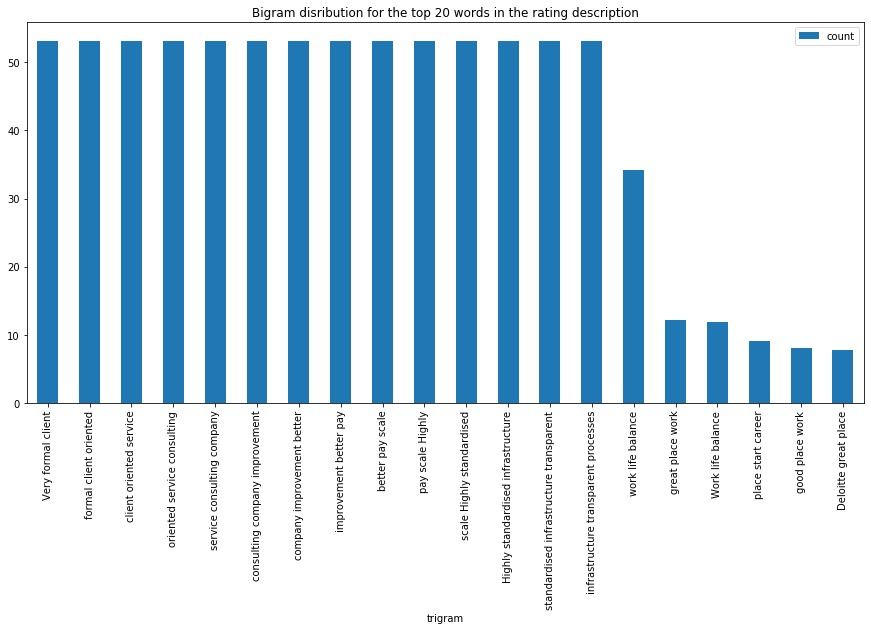

In [10]:
# Trigram distribution

#Converting text rating descriptions into vectors using TF-IDF using Trigram

tf_vector = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
matrix_tf = tf_vector.fit_transform(data['rating_description'])
words_count = matrix_tf.sum(axis=0) 
#Finding the word frequency
frequency = [(word, words_count[0, idx]) for word, idx in tf_vector.vocabulary_.items()]
frequency =sorted(frequency, key = lambda x: x[1], reverse=True)
#converting into dataframe 
trigram = pd.DataFrame(frequency)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)
#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the rating description", figsize = (15,7), )



In [11]:
# Function for removing NonAscii
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

In [12]:
# Function to convert into lower characer
def make_lower_case(text):
    return text.lower()

In [13]:
# Function to remove stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [15]:

# Function to remove punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [16]:

# Applying all the functions in description and storing as a cleaned_desc
data['rating_desc_cleaned'] = data['rating_description'].apply(_removeNonAscii)
data['rating_desc_cleaned'] = data.rating_desc_cleaned.apply(func = make_lower_case)
data['rating_desc_cleaned'] = data.rating_desc_cleaned.apply(func = remove_stop_words)
data['rating_desc_cleaned'] = data.rating_desc_cleaned.apply(func=remove_punctuation)


In [18]:
data['pos_tags'] = data['rating_desc_cleaned'].apply(nltk.tag.pos_tag)

In [27]:
data['tokenized'] = data['rating_desc_cleaned'].apply(word_tokenize)

In [28]:
data.head()

,rating,rating_title,rating_description,rating_pros,rating_cons,word_count,rating_desc_cleaned,pos_tags,sentiment,tokenized
0,3.0,Good culture and peers,Very formal client oriented service consulting...,NaN,NaN,19,formal client oriented service consulting comp...,"[(f, NN), (o, MD), (r, VB), (m, VB), (a, DT), ...",0.330000,"[formal, client, oriented, service, consulting..."
1,5.0,Productive and competitive workplace with many...,During a typical day at work we attend any cus...,"innovation, leading skills, be part of Deloitt...","Not at all, I love working.",106,typical day work attend customer requirements ...,"[(t, NN), (y, NN), (p, NN), (i, NN), (c, VBP),...",0.321528,"[typical, day, work, attend, customer, require..."
2,2.0,Very stressful,Company is very focused on their profits rathe...,Great benefits,Extremely demanding,32,company focused profits rather accommodating n...,"[(c, NNS), (o, VBP), (m, JJ), (p, NN), (a, DT)...",0.200000,"[company, focused, profits, rather, accommodat..."
3,5.0,Excellent culture,The project I worked in is relaxed. The overal...,NaN,NaN,26,project worked relaxed overall company culture...,"[(p, NN), (r, NN), (o, IN), (j, NN), (e, NN), ...",0.267273,"[project, worked, relaxed, overall, company, c..."
4,5.0,I love Deloitte!,Honestly if you feel like applying to work at ...,Treated equally,N/a,28,honestly feel like applying work deloitte so l...,"[(h, NN), (o, MD), (n, VB), (e, NN), (s, JJ), ...",0.500000,"[honestly, feel, like, applying, work, deloitt..."


In [ ]:
## Sentiment Analysis


In [38]:
data['sentiment'] = data['rating_desc_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [30]:
data.head()

,rating,rating_title,rating_description,rating_pros,rating_cons,word_count,rating_desc_cleaned,pos_tags,sentiment,tokenized
0,3.0,Good culture and peers,Very formal client oriented service consulting...,NaN,NaN,19,formal client oriented service consulting comp...,"[(f, NN), (o, MD), (r, VB), (m, VB), (a, DT), ...",0.330000,"[formal, client, oriented, service, consulting..."
1,5.0,Productive and competitive workplace with many...,During a typical day at work we attend any cus...,"innovation, leading skills, be part of Deloitt...","Not at all, I love working.",106,typical day work attend customer requirements ...,"[(t, NN), (y, NN), (p, NN), (i, NN), (c, VBP),...",0.321528,"[typical, day, work, attend, customer, require..."
2,2.0,Very stressful,Company is very focused on their profits rathe...,Great benefits,Extremely demanding,32,company focused profits rather accommodating n...,"[(c, NNS), (o, VBP), (m, JJ), (p, NN), (a, DT)...",0.200000,"[company, focused, profits, rather, accommodat..."
3,5.0,Excellent culture,The project I worked in is relaxed. The overal...,NaN,NaN,26,project worked relaxed overall company culture...,"[(p, NN), (r, NN), (o, IN), (j, NN), (e, NN), ...",0.267273,"[project, worked, relaxed, overall, company, c..."
4,5.0,I love Deloitte!,Honestly if you feel like applying to work at ...,Treated equally,N/a,28,honestly feel like applying work deloitte so l...,"[(h, NN), (o, MD), (n, VB), (e, NN), (s, JJ), ...",0.500000,"[honestly, feel, like, applying, work, deloitt..."


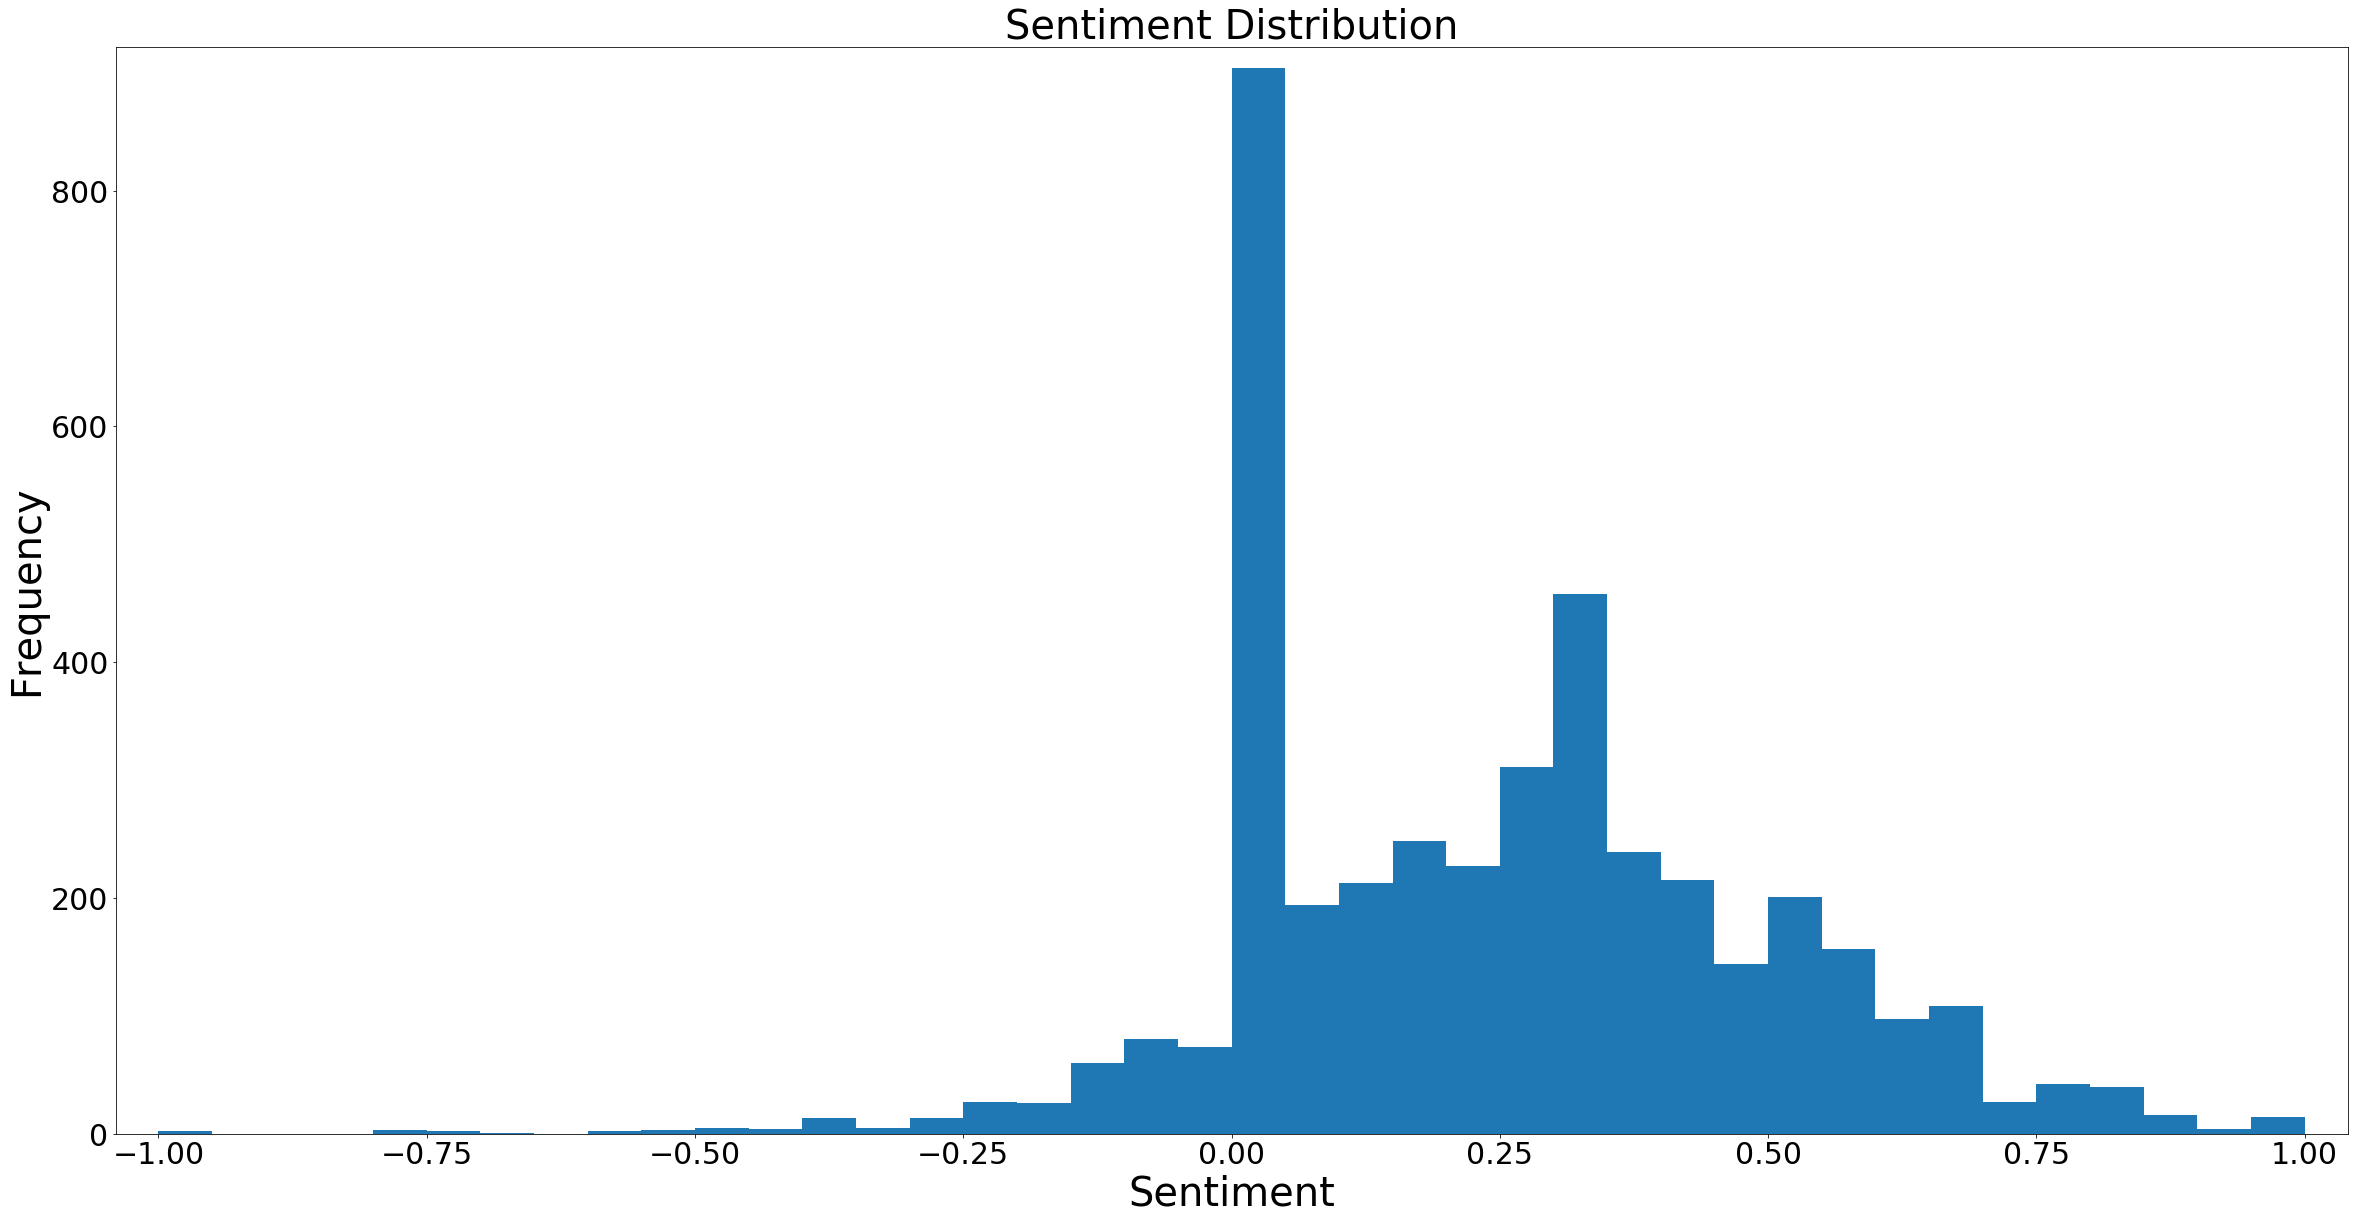

In [22]:
# plotting the sentiment distribution
plt.figure(figsize=(40,20))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize = 40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Frequency', fontsize = 40)
plt.hist(data['sentiment'], bins = 40)
plt.title('Sentiment Distribution', fontsize=40)
plt.show()

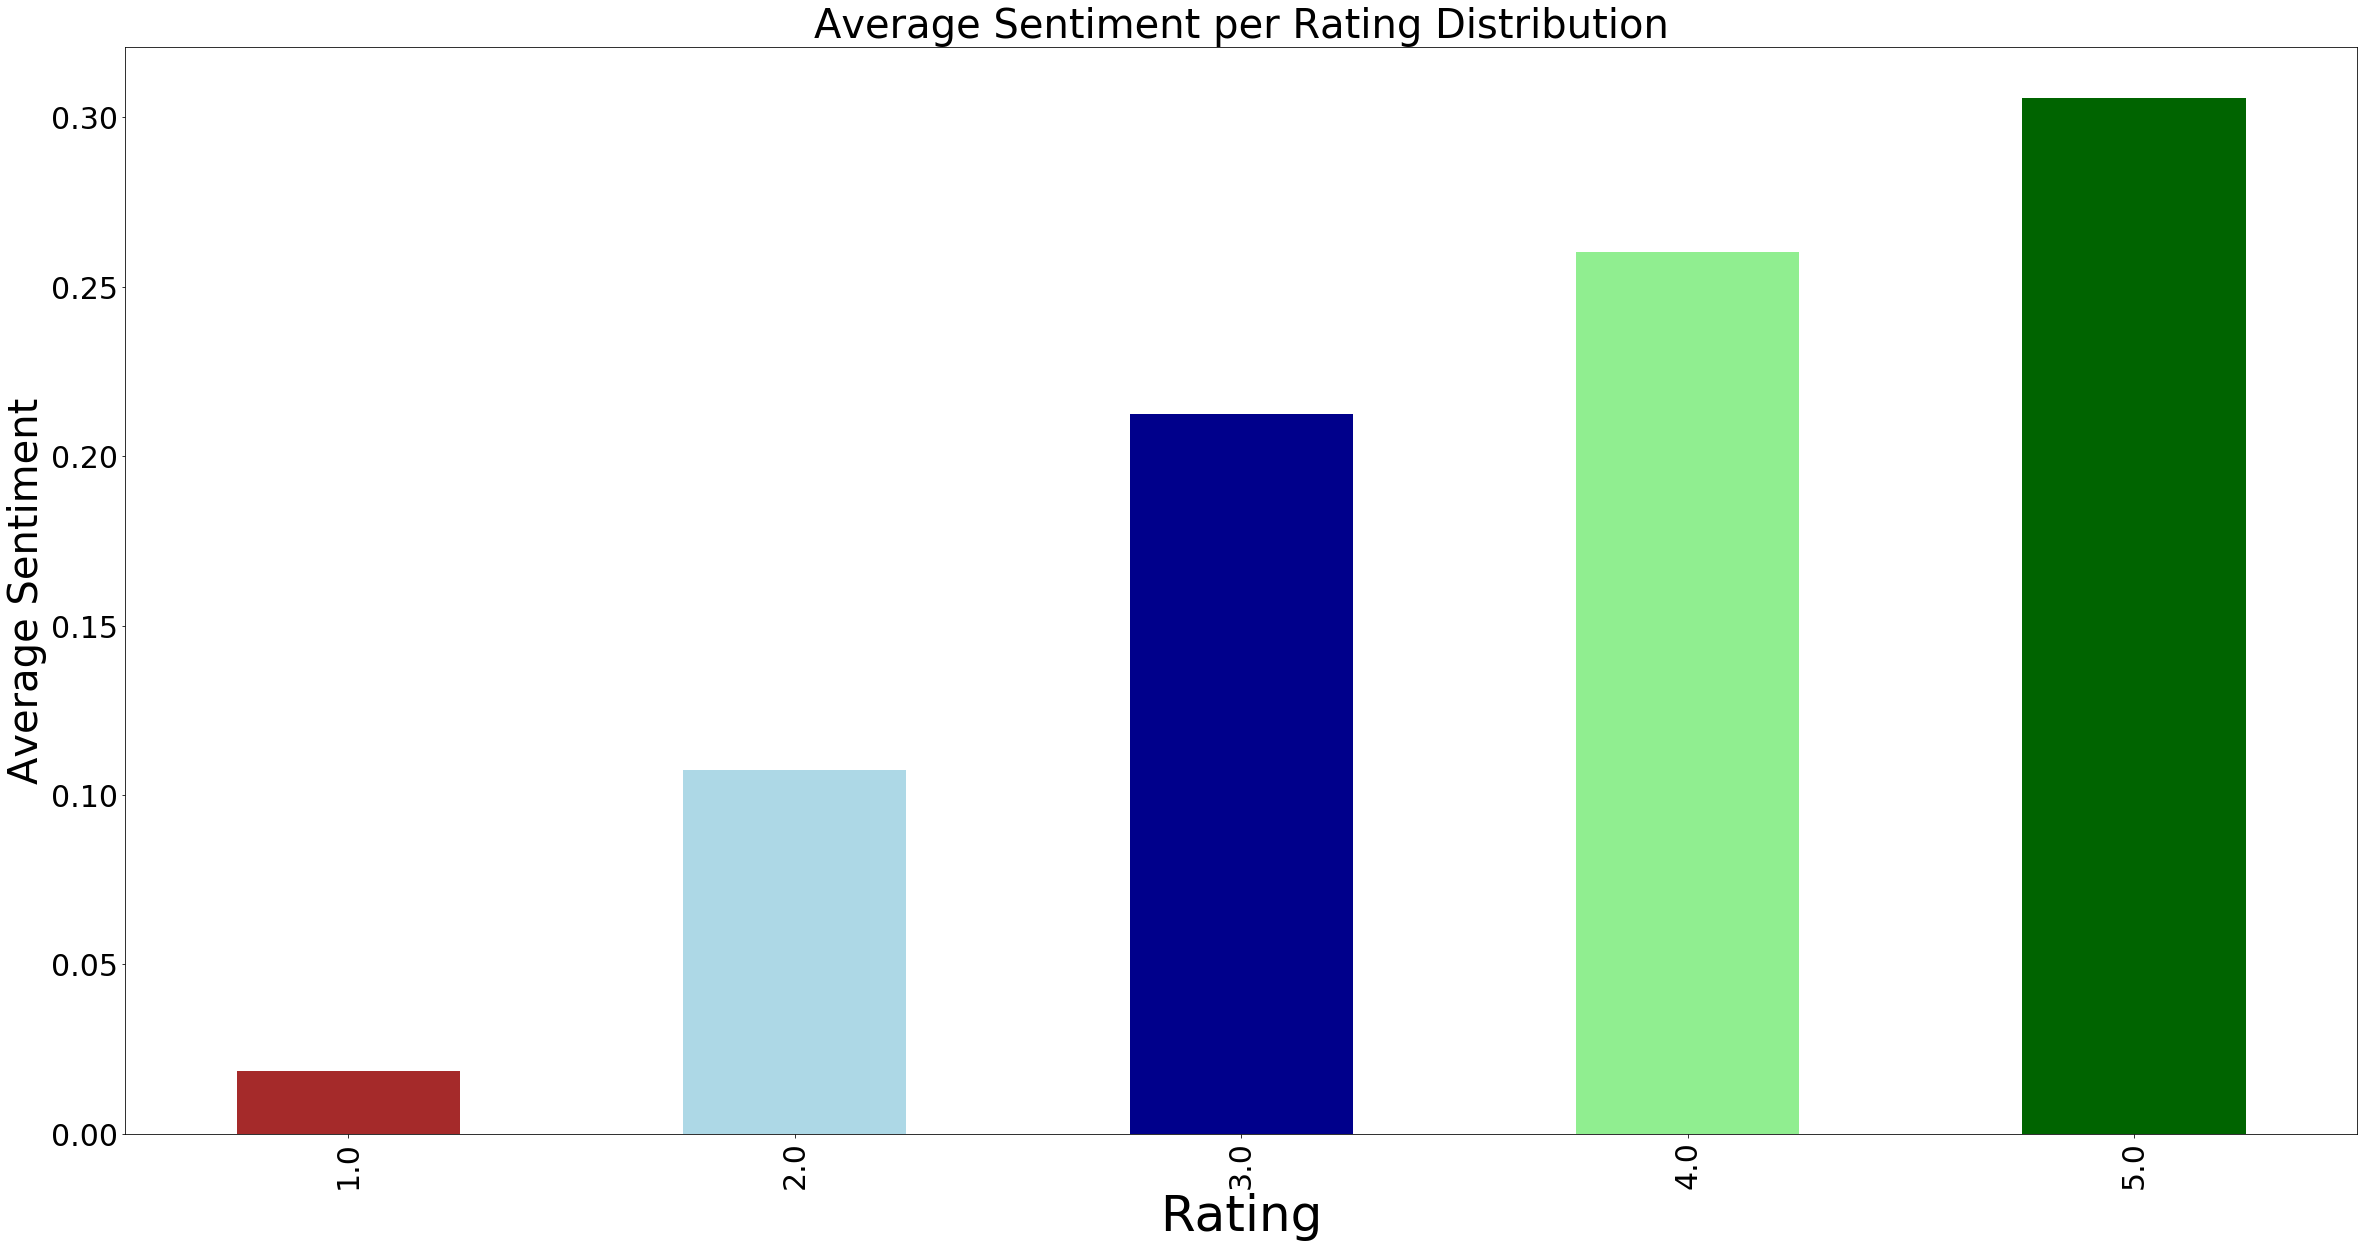

In [84]:
colors = ['brown', 'lightblue', 'darkblue', 'lightgreen', 'darkgreen']
avg = data.groupby('rating')['sentiment'].mean().plot(kind='bar', color = colors, figsize=(40,20))
plt.xlabel('Rating', fontsize=50)
plt.ylabel('Average Sentiment', fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Average Sentiment per Rating Distribution', fontsize=40)
plt.show()


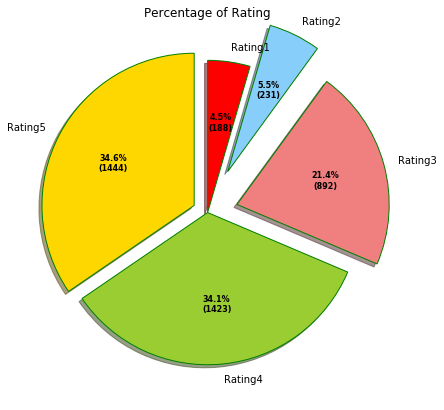

In [24]:
# Creating explode data
explode = (0.1, 0.0, 0.2, 0.3, 0.0)
labels = 'Rating5', 'Rating4', 'Rating3', 'Rating2','Rating1'
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']
  
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data.rating.value_counts(),
                                  autopct = lambda pct: func(pct, data.rating.value_counts()),
                                  explode = explode, 
                                  labels = labels,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))

  
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Percentage of Rating")
  
# show plot
plt.show()

In [31]:
words = data['tokenized']
allwords = []
for wordlist in words:
    allwords +=wordlist
print(allwords)

['formal', 'client', 'oriented', 'service', 'consulting', 'company', 'improvement', 'better', 'pay', 'scale', 'highly', 'standardised', 'infrastructure', 'transparent', 'processes', 'typical', 'day', 'work', 'attend', 'customer', 'requirements', 'send', 'email', 'matter', 'site', 'remote', 'due', 'cov19', 'assignations', 'job', 'always', 'amazing', 'since', 'perspective', 'reviewing', 'process', 'forms', 'reports', 'interfaces', 'flow', 'information', 'always', 'leading', 'get', 'opportunities', 'enhance', 'processes', 'training', 'users', 'getting', 'things', 'done', 'i', 'love', 'management', 'since', 'always', 'responsible', 'respectful', 'think', 'workplace', 'culture', 'best', 'always', 'good', 'communications', 'always', 'many', 'projects', 'ideas', 'make', 'us', 'keep', 'interested', 'technology', 'next', 'steps', 'company', 'focused', 'profits', 'rather', 'accommodating', 'needs', 'employees', 'great', 'place', 'network', 'exhausting', 'keep', 'compliance', 'metrics', 'project'

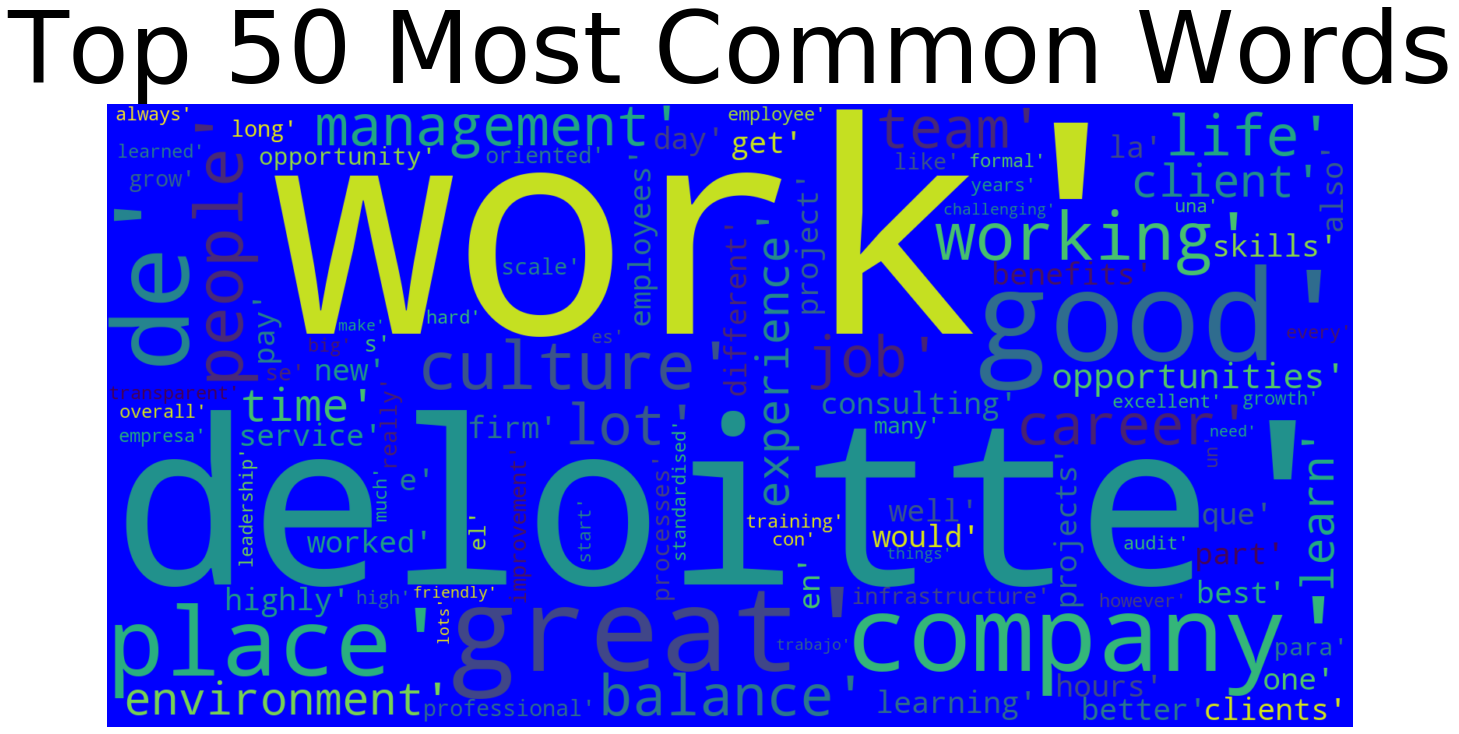

In [32]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud

fdist = FreqDist()
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='blue').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

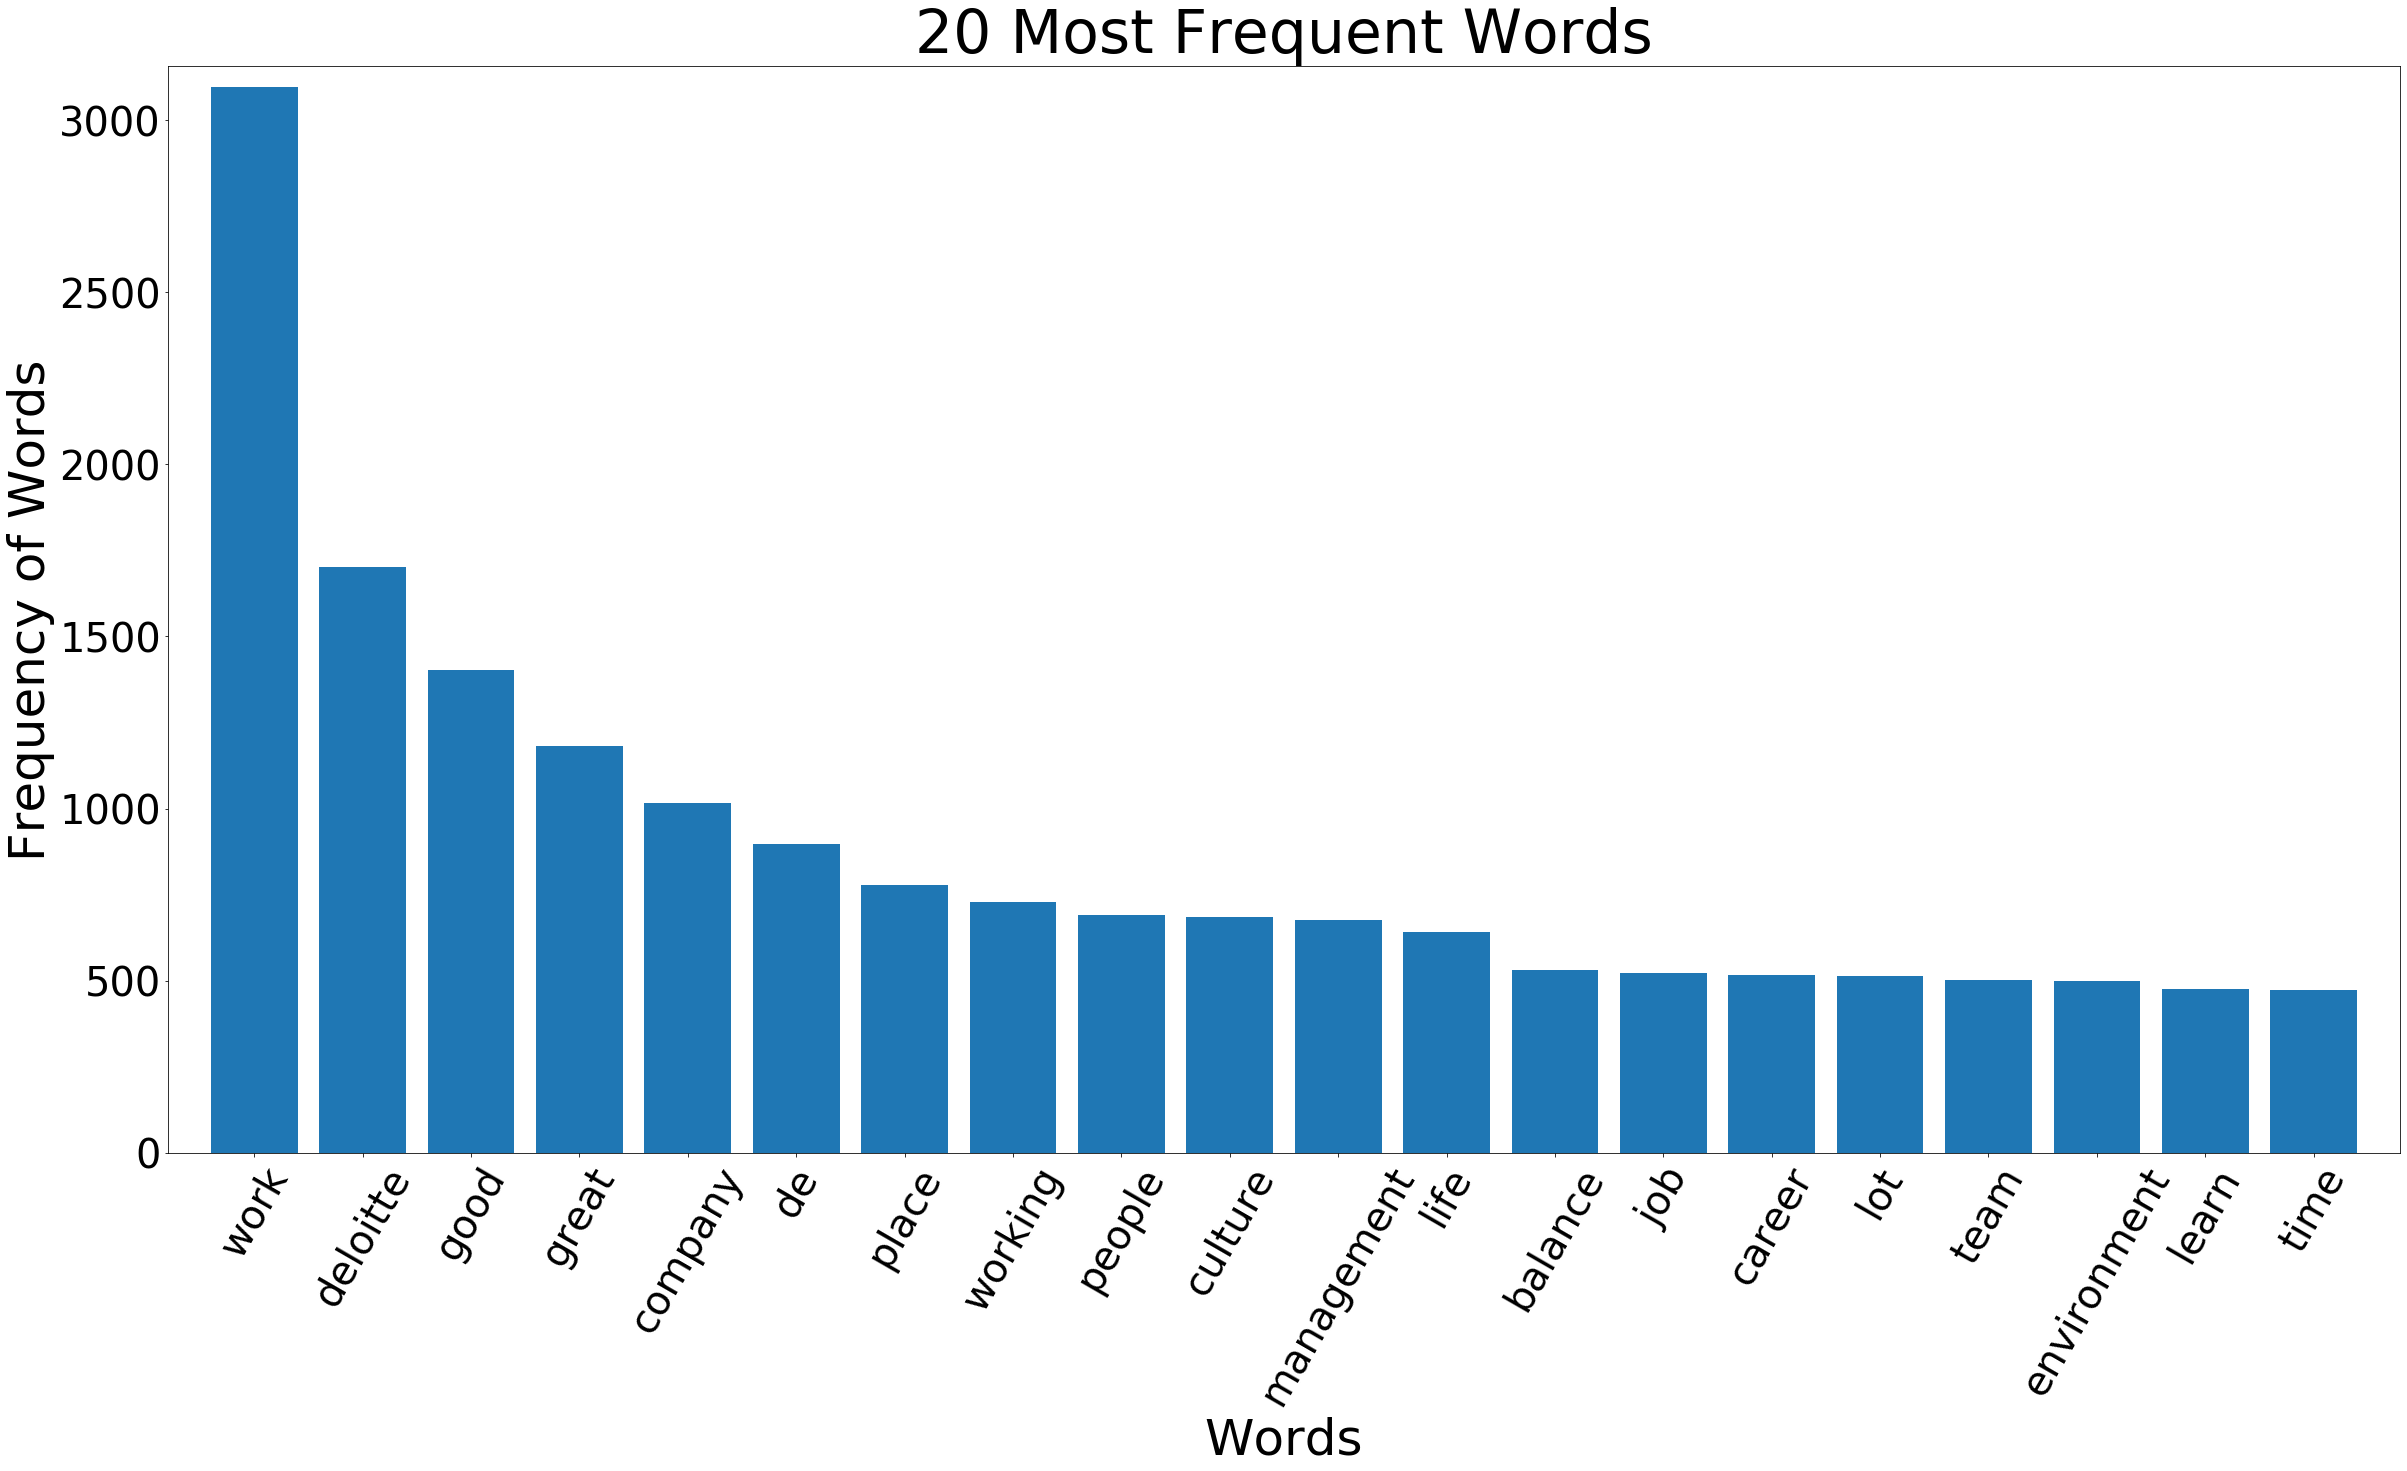

In [35]:
# plot 20 most frequent words
common_word = FreqDist(allwords).most_common(20)
x, y = zip(*common_word)
plt.figure(figsize=(40,20))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('20 Most Frequent Words', fontsize=60)
plt.show()

In [75]:
# CountVectorizer Method
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=20, max_features=4000)
tf = tf_vectorizer.fit_transform(data['rating_desc_cleaned'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix.head()

,10,12,30,ability,able,accounting,achieve,across,activities,advance,...,workload,workplace,works,world,worth,would,year,years,you,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda_model, tf_feature_names, no_top_words)


Topic 0:
de la en que el es con para se una
Topic 1:
work project deloitte good firm company employees management one job
Topic 2:
de empresa que uma para com muito se trabalho est
Topic 3:
deloitte great place work career experience learn opportunity professional working
Topic 4:
team client clients year audit every hours industry end system
Topic 5:
consulting service better highly client company pay processes oriented improvement
Topic 6:
challenging di et per un available le non poor professionals
Topic 7:
work job part day many time get things typical management
Topic 8:
work good great life balance culture place company environment management
Topic 9:
deloitte would people time company working work years worked recommend


In [80]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(data['rating_desc_cleaned'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,10,12,ability,able,accounting,across,activities,advance,advancement,advisory,...,working,workplace,works,world,worth,would,year,years,you,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.123135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.372247,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)




Topic 0:
job team part day management time working hours people work
Topic 1:
standardised formal transparent infrastructure scale improvement oriented processes service highly
Topic 2:
de et travail des trs trabajo les une la trabalho
Topic 3:
good management culture environment learning benefits overall company experience working
Topic 4:
en el que la es se con un una trabajo
Topic 5:
great people place benefits culture opportunities company work learning environment
Topic 6:
work life balance hours culture home difficult flexible however hard
Topic 7:
deloitte working one experience company employees best firm years worked
Topic 8:
empresa para uma com excelente que muito aprender em trabalho
Topic 9:
learn place career lot grow skills start get different new
